# ISPC phase searc match

Notebook iterating gamma. I use this to generate experimental phases used for the analysis.

### Imports

In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, FastSpectraXRD, GaussNewton,
    PhaseList, ChiSearch, GammaMap, ChiMap, Phase, PhaseList, GammaSearch_Secondary, GammaMap_Secondary)

from os.path import isdir
from os import makedirs
from shutil import rmtree

import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import (linspace, concatenate, sqrt, log, sin, pi, histogram, array, unravel_index, savetxt,
    flip, sum, average, amax, arange)
import pandas as pd

from matplotlib.pyplot import (sca, show, fill_between, legend, imshow, subplots, plot, xlim, ylim,
    xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines, savefig, get_cmap)
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.markers import MarkerStyle
from matplotlib.colors import BoundaryNorm

from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool

from glob import glob
from PIL import Image

from pathlib import Path


def f_linear(x,a,b):
    return a*x + b


def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y


def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


def correct_point(experimental_phases, idx_phase, gm, x, y):
    gn = gm.get_pixel(x, y)[idx_phase]
    phase = gn.make_phase()
    phase.set_name('created_%d'%idx_phase)
    phase.set_point(gm.get_index(x, y))
    experimental_phases[idx_phase] = phase

    
def rename_phase_in_database(database, name_old, name_new):
    for p in database[name_old]:
        p['_chemical_name_mineral'] = name_new
    database[name_new] = database[name_old]
    del database[name_old]


rcParams.update({
'image.origin': 'lower'
})

# Define paths and parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/'
path_xrd = path_scan + 'AngeloXRD/'           # XRD scan 
path_xrf = path_scan + 'AngeloXRF/'           # XRF scan
path_photo = path_scan + 'AngeloFoto/'        # photo of the scanned section
path_zmap = path_shared + 'VenereBZPosition/'
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'MunchMuseum/M491/'
path_figures = 'figures/' + subfolder_output          # figures generated by the script
path_results = 'results/' + subfolder_output          # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

### Parameters ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
rmtree(path_figures)
rmtree(path_results)
rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

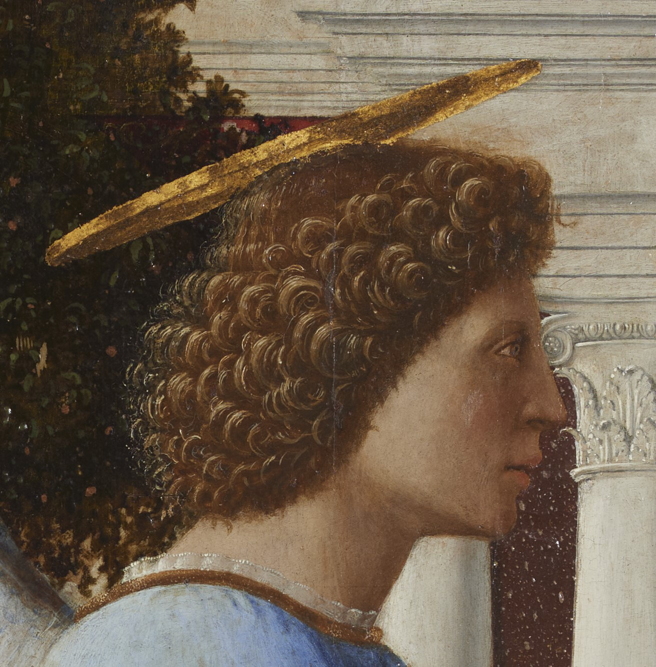

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.resize([s // 2 for s in im.size]))

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
%matplotlib inline
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to recalculate h5 file, change this filename
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background().save_h5(path_xrd + 'xrd.h5')
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5
Shape of data: (188, 140, 1280)
Initial calibration:
a = -1172.8, s = 2053.1, beta = 50.710
Theta range [20.974350647292493, 53.699886668557056]

Phases in database: 350


### Correct burnt pixel
Selects the pixel with the maximum value and substitutes all its channel with a constant lower value

In [7]:
# array_max = data.data.max(axis=2)
# print(array_max.argmax())
# idx = unravel_index(array_max.argmax(), array_max.shape)
# print(idx)
# data.data[idx] = array_max.min()

### Show aggregated information about XRD data

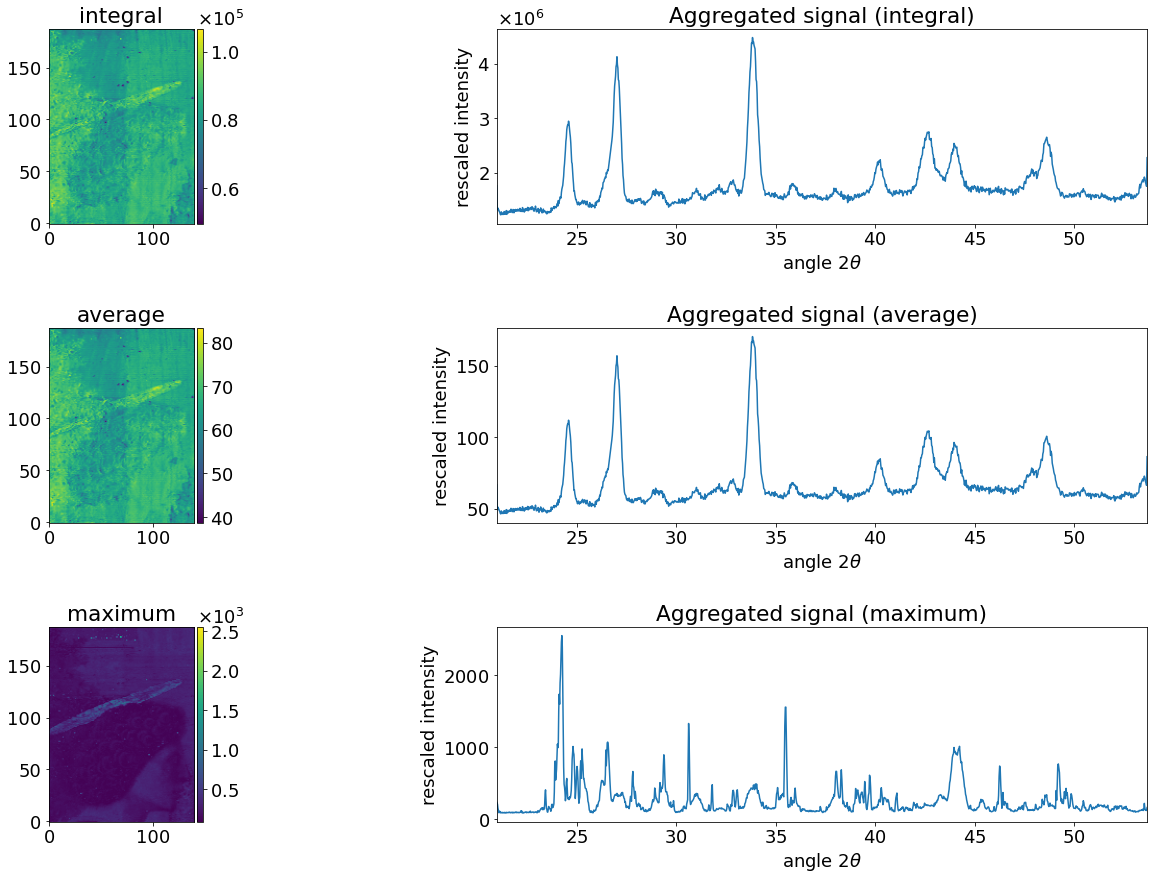

In [8]:
rcParams['font.size'] = 18

fig, axs = subplots(3, 2, figsize = (20, 12))
fig.tight_layout(h_pad = 4, w_pad = 0)

theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
for i in range(len(list_aggregations)):

    image_aggregated = list_functions[i](data.data, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated)
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])

    xrdpattern_aggregated = list_functions[i](data.data.reshape((-1, data.data.shape[-1])), axis = 0)
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('rescaled intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

### Show rescaling and signal / background ratio

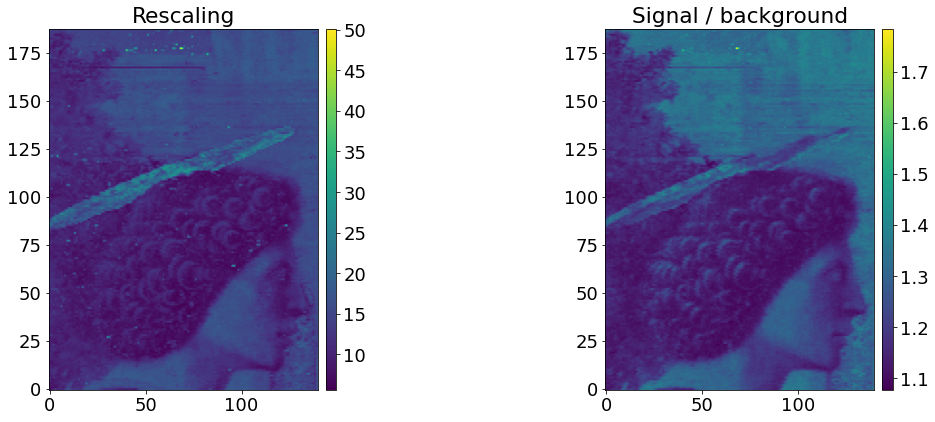

In [9]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 6))
fig.tight_layout(w_pad = 4)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze()**0.5)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')

ax = axs[1]
im = ax.imshow(data.signal_background_ratio.squeeze())
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal / background')

show()

# Read z position and laser correction

In [10]:
list_z = []
list_laser = []

filenames = sorted(glob(path_zmap + '/*.txt'))
for filename in filenames:
    df = pd.read_csv(filename, sep = '\s+')
    list_z.append(df['Z'].values)
    list_laser.append(df['Laser'].values)

matrix_z = array(list_z)
matrix_laser = array(list_laser)
matrix_sum_z_laser = matrix_z + matrix_laser

### Show maps

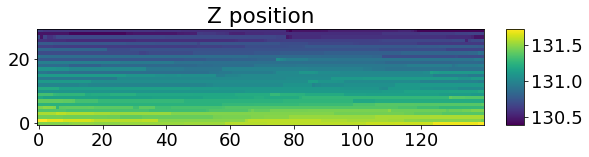

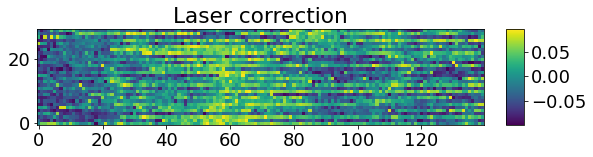

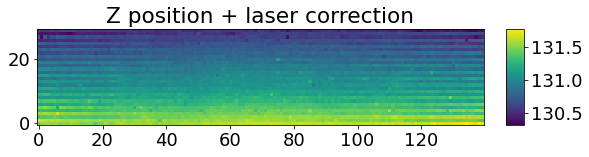

In [11]:
rcParams['font.size'] = 18

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_z)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Z position')
show()

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_laser)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Laser correction')
show()

fig, ax  = subplots(figsize = (8, 6))
im = ax.imshow(matrix_sum_z_laser)
colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
ax.set_title('Z position + laser correction')
show()

# Read XRF images

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [14]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [0]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 22 images


### Show XRF images

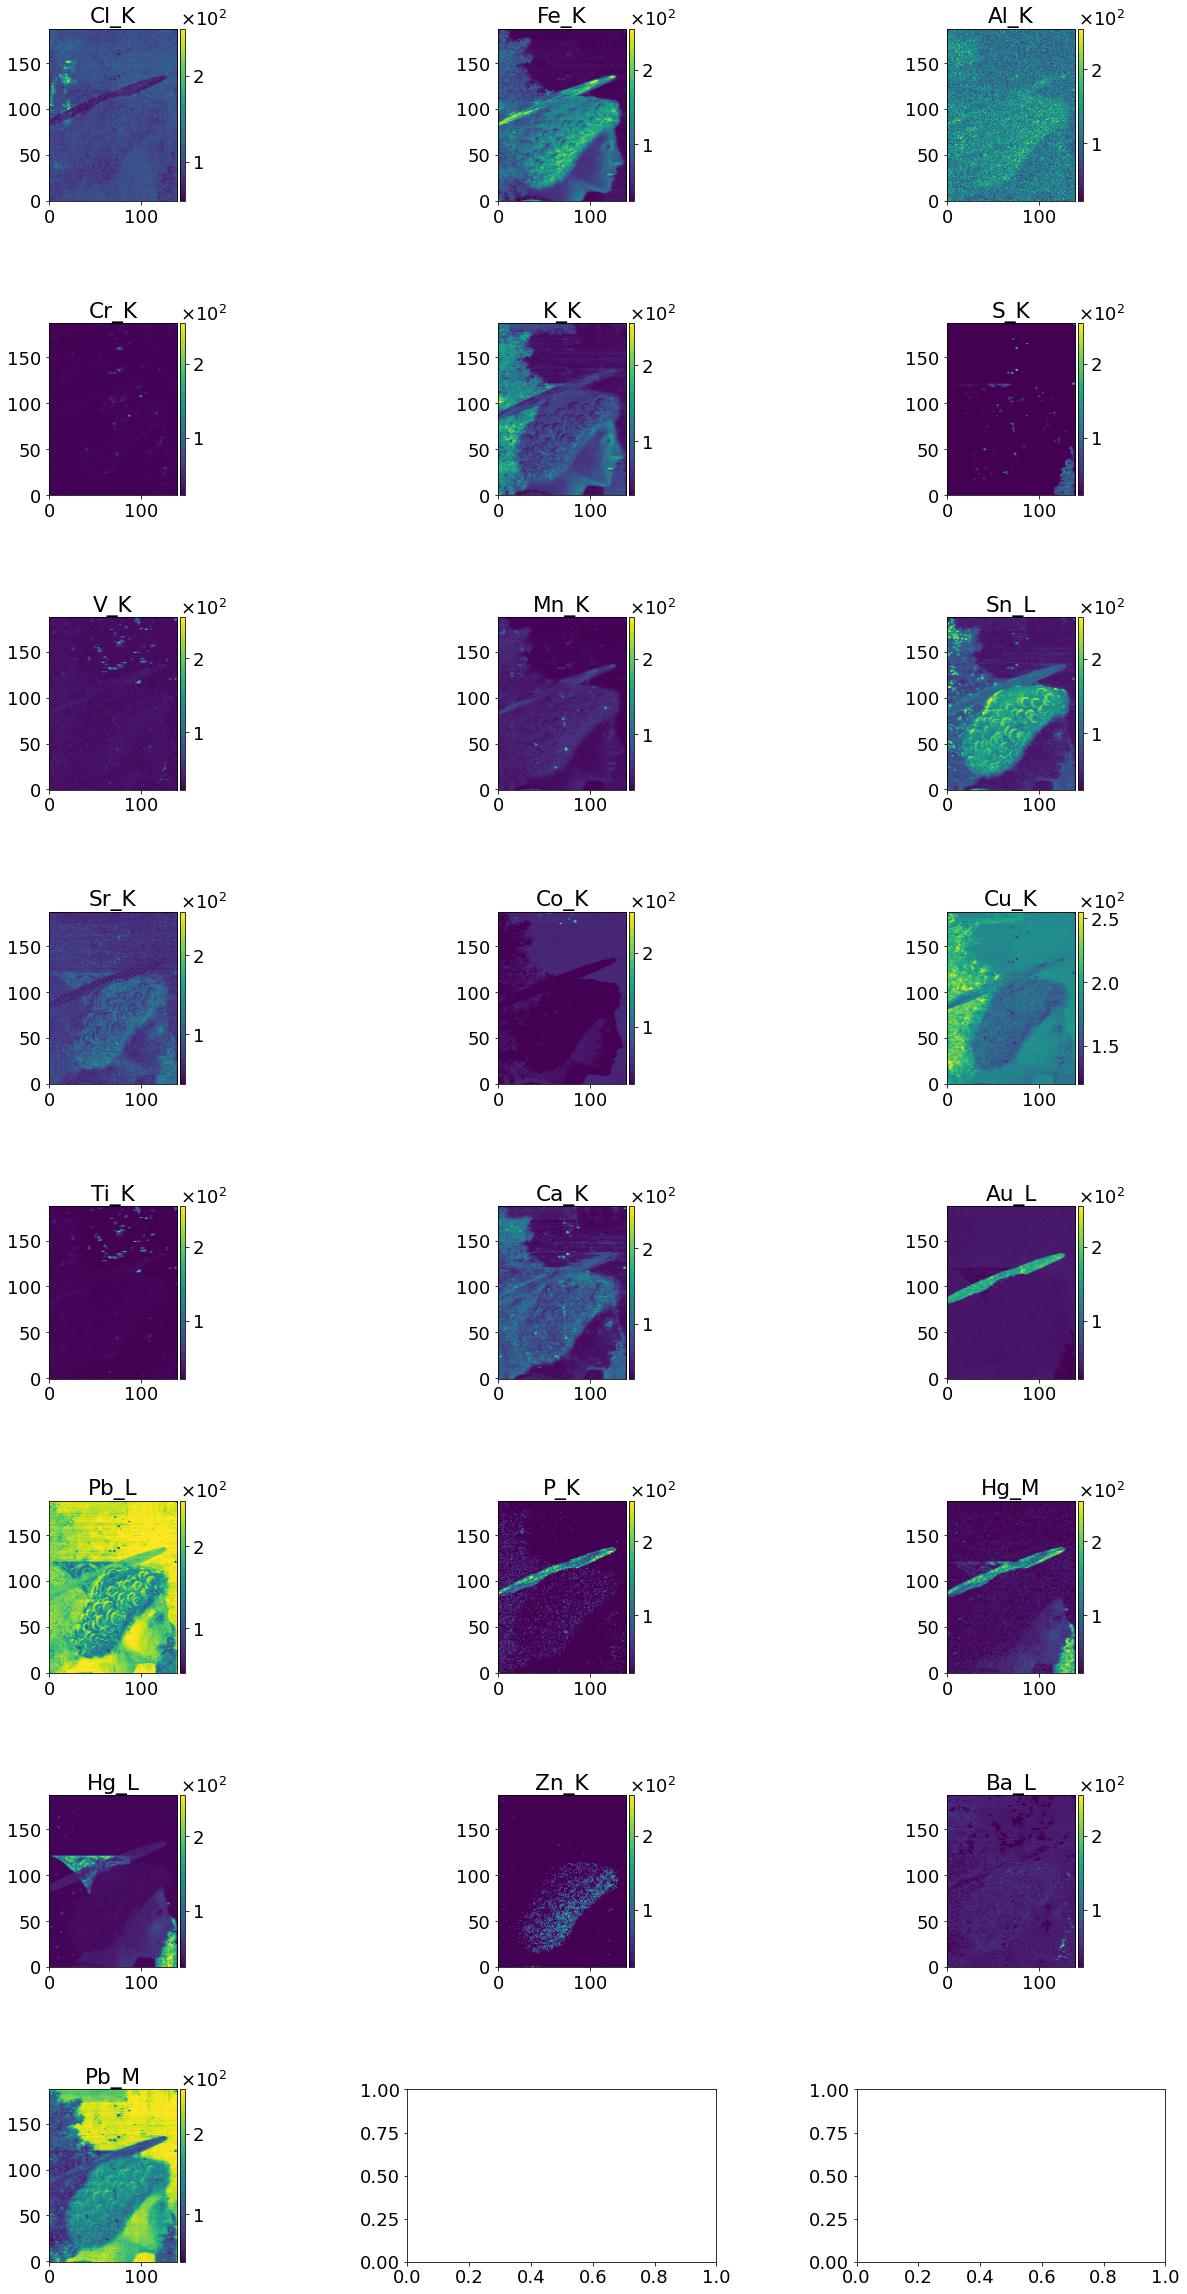

In [15]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(data_xrf.metadata['labels'])
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, label in enumerate(data_xrf.metadata['labels']):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    im = ax.imshow(data_xrf.labels[..., i])
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(label)
show()

## Define phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [27]:
rename_phase_in_database(database, 'Pb2 Sn O4', 'Lead-tin yellow')

In [37]:
### PRIMARY ###
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
gold = database['Gold'][0]
yellow_lt = database['Lead-tin yellow'][0]
gypsum = database['Gypsum'][0]

### SECONDARY ###
hematite = database['Hematite'][4]
bone_black = database['Bone_Black'][0]
goethite = database['Goethite'][0]

### Explore phase database

See the phases in the database that contain all of the chosen elements.

In [38]:
elements_chosen = ['Pb', 'Sn']

list_name = []
list_formula = []
list_number = []
for k, v in sorted(database.items()):
    p = v[0]
    if '_chemical_formula_sum' in p:
        if all(e in p['_chemical_formula_sum'] for e in elements_chosen):
            list_name.append(k)
            list_formula.append(p['_chemical_formula_sum'])
            list_number.append(len(v))

pd.DataFrame(
    columns = ['Name in database', 'Chemical formula', 'Number of samples'],
    data = array([list_name, list_formula, list_number]).T
)#.iloc[0:3] # if there are too many lines, change this to select the lines you see

Name in database Chemical formula Number of samples
0  Lead-tin yellow        Pb2 Sn O4                 1

### Plot XRF of selected element

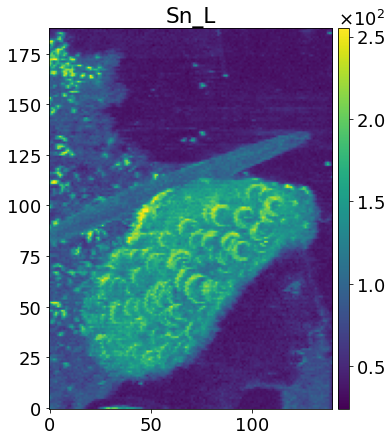

In [39]:
%matplotlib inline
#%matplotlib qt
rcParams['font.size'] = 18

element_chosen = 'Sn'

for i, label in enumerate(data_xrf.metadata['labels']):
    #if element_chosen in label:   # search for the given string in XRF label
    if element_chosen + '_' in label:   # search for the given string + '_' in XRF label
        fig, ax  = subplots(figsize = (10, 7))
        title(label)
        im = ax.imshow(data_xrf.labels[..., i])
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title(label)
show()

### Check phases in a given point

Hydrocerussite (C H O4 Pb1.5)


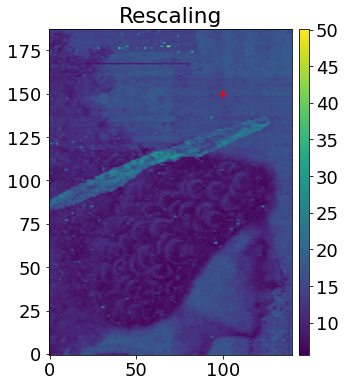

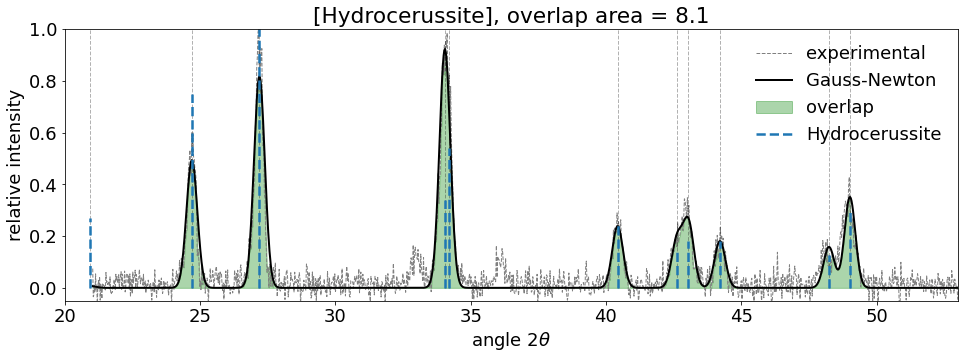

In [40]:
%matplotlib inline
x, y = 100, 150
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 6))
im = ax.imshow(data.rescaling.squeeze()**0.5)
ax.scatter(x, y, s = 50, c = 'red', marker = '+')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')

phases_new = PhaseList([hydrocerussite])

for p in phases_new:
    print(p.label, end = '')
    if '_chemical_formula_sum' in p:
        print (' (' + p['_chemical_formula_sum'] + ')')

gn = GaussNewton(phases_new, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
#gn.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2.5, alpha = 1)
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap area = {gn.overlap3_area():.1f}')
legend(frameon = False)
show()

# Search for primary phases

Adjust initial calibration. This can be executed after the first fit finds a better initial calibration.

### Change initial calibration

In [41]:
# opt_calibration_ini = data.opt
# print('Calibration parameters from calibration.ini:', opt_calibration_ini)
# data.opt = array([-1164.78443104,  2041.65595205,    50.71024209])

In [51]:
if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

### Create data structure

In [53]:
phases_primary = [hydrocerussite, cinnabar, gold, yellow_lt, gypsum]

In [54]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [55]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 28.1 s, sys: 3.02 s, total: 31.2 s
Wall time: 41.8 s


#### Fast mapping

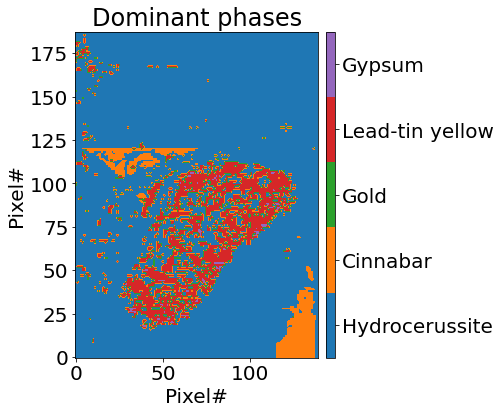

In [56]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (6, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(phases_primary) + 0.5, 1), len(phases_primary))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(phases_primary)))
cbar.set_ticklabels([p.label for p in phases_primary])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Histogram of $a$

If $a$ is spead over too large area it means that fitting went wrong. Maybe we need to add phases.

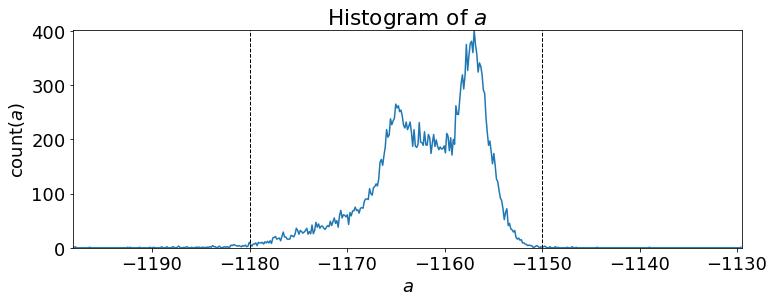

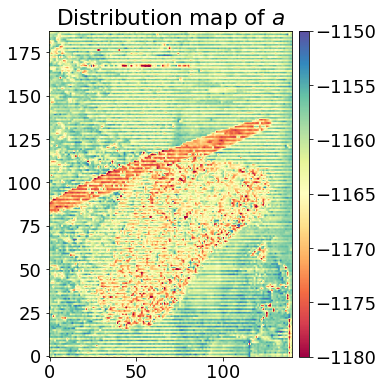

In [57]:
%matplotlib inline
rcParams['font.size'] = 18

opt = gm.opt()
a = opt[..., 0]
s = opt[..., 1]

### Set them for better representation of color map ###
vmin = -1180
vmax = -1150

h, b = histogram(a, bins = 512)

fig, ax = subplots(figsize = (12, 4))
plot(b[:-1], h)
xlim(b[0], b[-1])
ylim(0,h.max())
vlines(vmin, 0, h.max(), 'k', ls = '--', lw = 1)
vlines(vmax, 0, h.max(), 'k', ls = '--', lw = 1)
xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')
savefig(path_figures + f'histogram_a_ROI({vmin},{vmax}).png')

fig, ax = subplots(figsize = (12, 6))
title('Distribution map of $a$')
im = imshow(a, cmap = 'Spectral', vmin = vmin, vmax = vmax)
colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
savefig(path_figures + f'distribution_map_a_ROI({vmin},{vmax}).png')

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $a, s$ dependence but it is weak.

Linear: [-1.75391629  5.98759224]
Cauchy: [-7.27731069e-01  1.19370493e+03]
mean a,s: -1161.7455899467875 2043.5921127010324
most probable a,s: -1156.9605262420273 2035.6610498862008


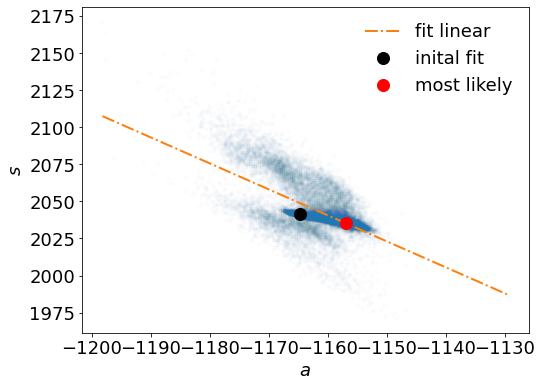

In [58]:
%matplotlib inline
rcParams['font.size'] = 18

opt, var = curve_fit(f_linear, a.flatten(), s.flatten())
res = least_squares(f_loss, x0 = opt, args = (a.flatten(), s.flatten()), loss = 'cauchy')
pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])
x = linspace(a.min(), a.max(), 10)
# linear_y = f_linear(a.flatten(), *opt)
# cauchy_y = f_linear(a.flatten(), *res['x'])

print('Linear:', opt)
print('Cauchy:', res['x'])
print('mean a,s:', a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(a.flatten(), s.flatten(), '.', alpha = 0.01)
ax.plot(x, f_linear(x, *opt), '-.', lw = 2, label = 'fit linear')
#ax.plot(x, f_linear(x, *res['x']), '--', lw = 2, label = 'fit cauchy')
ax.plot(data.opt[0], data.opt[1], 'ko', ms = 12, label = 'inital fit')
ax.plot(pmax_a, pmax_s, 'ro', ms = 12, label = 'most likely')
legend(frameon = False)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$s$')
savefig(path_figures + 'fit_a_s.png')
show()

### Quantify phase presence

In [59]:
correction = data.rescaling**0.5
#correction = data.signal_background_ratio

criterion = overlap_area * correction

### Criterion

Criterion for phase selection.

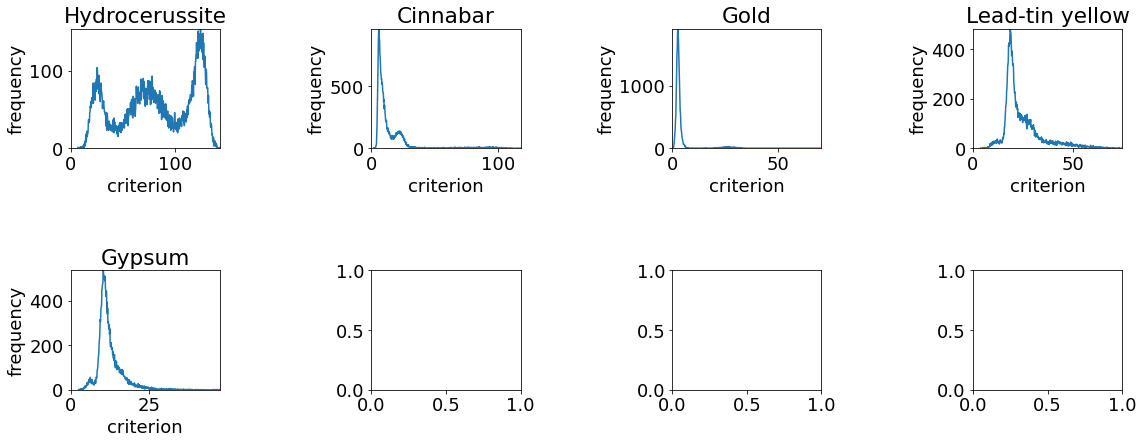

In [60]:
%matplotlib inline
n_of_columns = 4
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (4 * n_of_columns, 3 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(criterion[:, :, i], bins = 512)
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('criterion')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

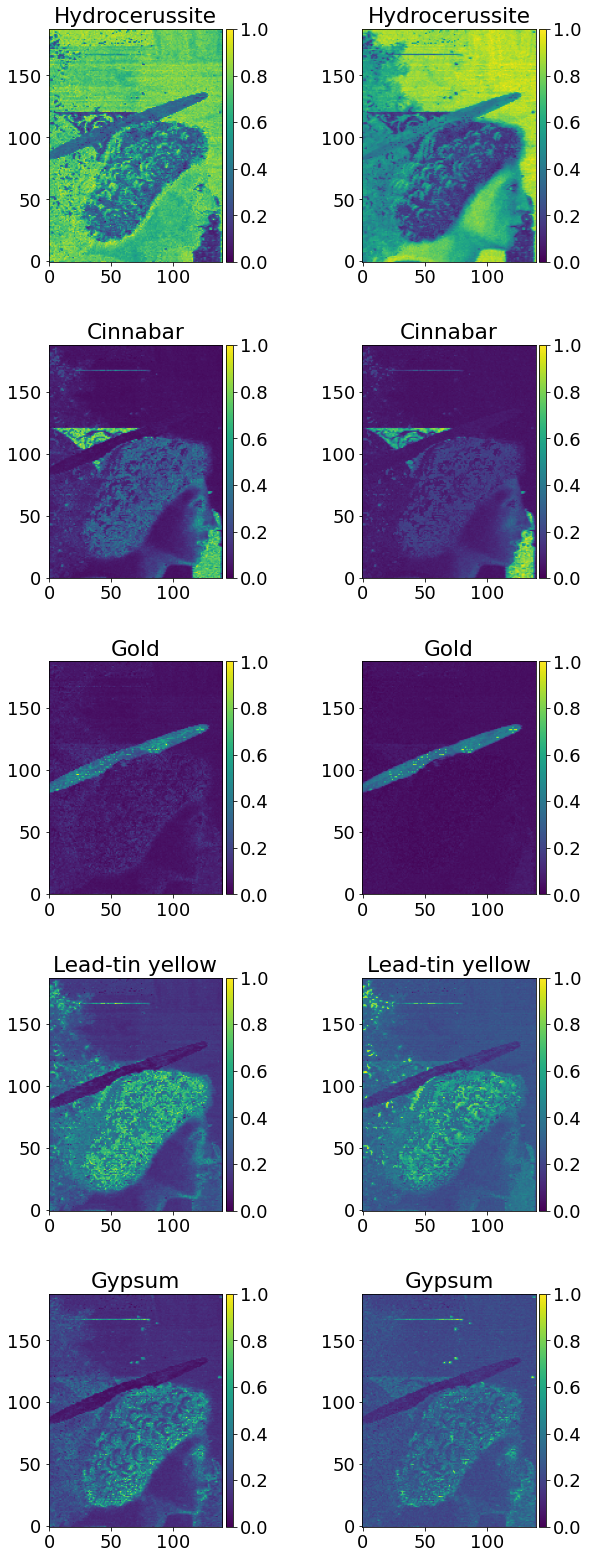

In [65]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm.phases), 2, figsize = (8, 4.5 * len(gm.phases)))
fig.tight_layout(h_pad = 0, w_pad = 5)

for i, phase in enumerate(gm.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]))

show()

Select a pixel for each phase based on 'criterion'

In [66]:
experimental_phases = gm.select_phases(criterion, -5)

### Show each phase from its selected pixel

Hydrocerussite (137, 82) 11617 [-1158.03685615  2036.28279341    50.71024209]
Cinnabar (136, 31) 4476 [-1157.58503353  2032.93905964    50.71024209]
Gold (81, 116) 16321 [-1157.70417932  2024.55622386    50.71024209]
Lead-tin yellow (2, 112) 15682 [-1173.40308075  2048.7916517     50.71024209]
Gypsum (62, 24) 3422 [-1158.68474191  2040.96336369    50.71024209]


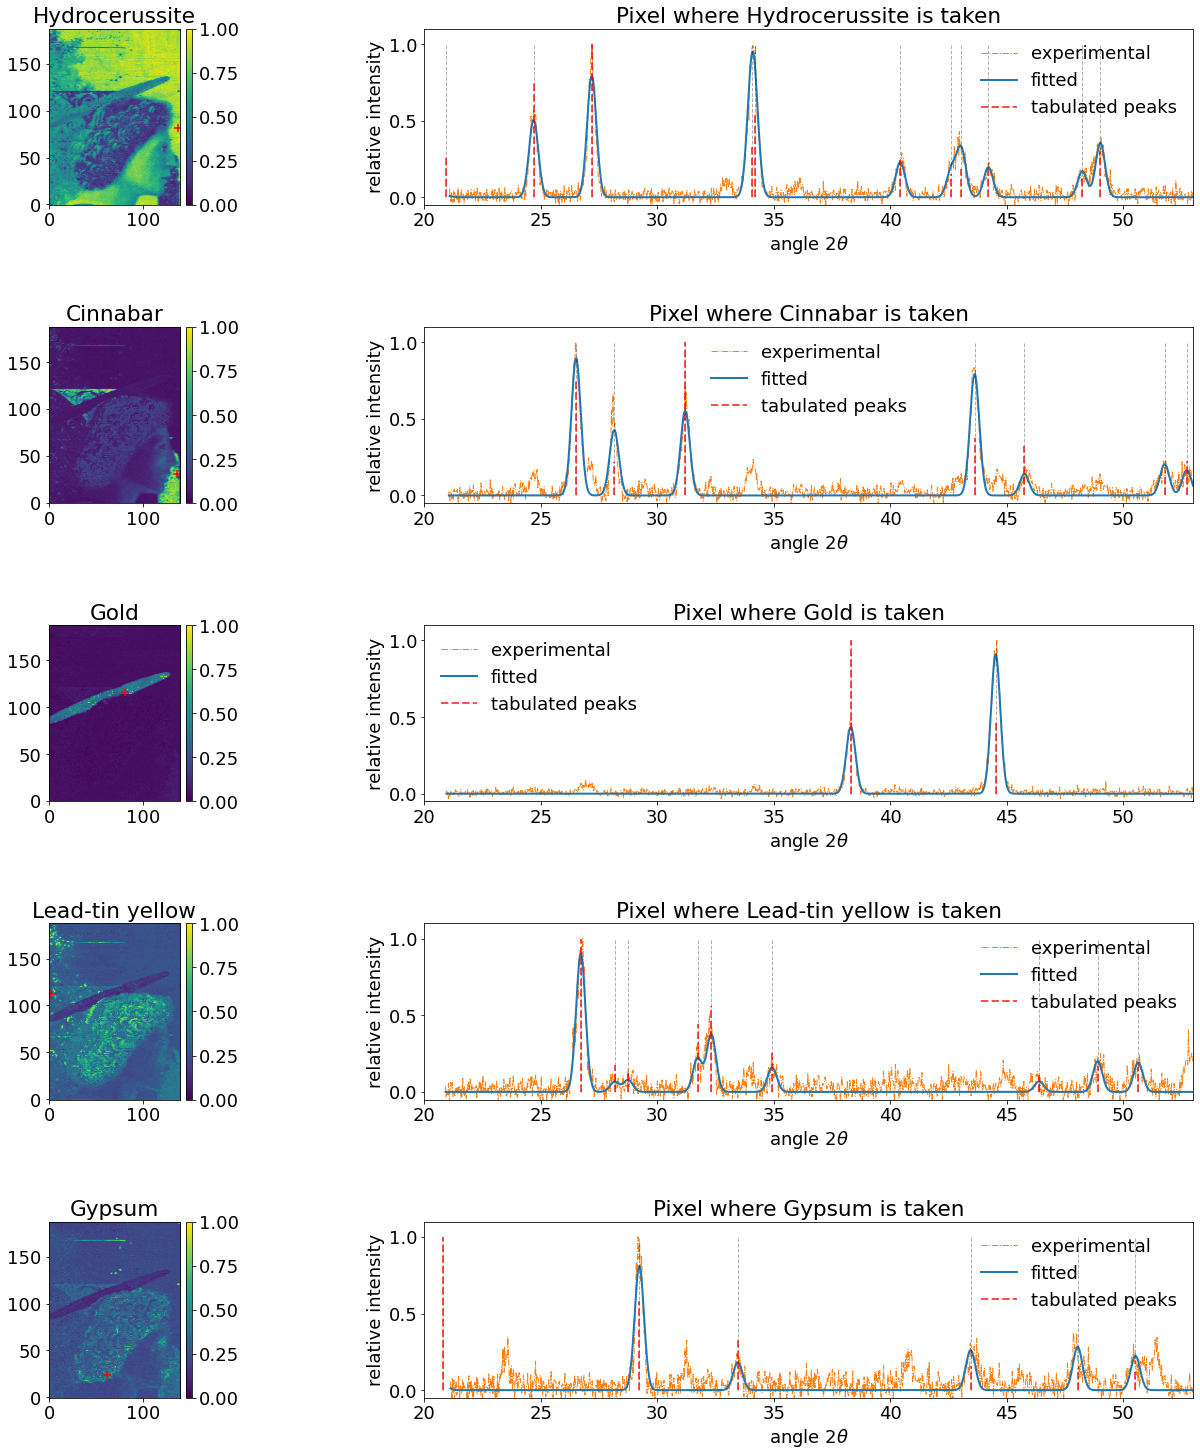

In [67]:
rcParams['font.size'] = 18

#matrix_plot = overlap_area.copy()
matrix_plot = criterion.copy()
matrix_plot /= matrix_plot.max(axis = 0, keepdims = True).max(axis = 1, keepdims = True)

fig, axs = subplots(len(gm.phases), 2, figsize = (18, 4*len(gm.phases)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, phase in enumerate(experimental_phases):

    if type(phase) == Phase:
        point = phase['point']
    else:
        point = phase[0]['point']
    x, y = gm.get_x_y(point)
    g = gm[point][i]

    if (len(experimental_phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    #cbar.set_label('overlap')
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(phase.label)

    if (len(experimental_phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    #g.fit_cycle(gamma = True, steps = 128,a=True,s=True)
    print(g.label, (x, y), point, g.opt)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'Pixel where {phase.label} is taken')
    legend(frameon=False)

    spectrum_to_save = array((g.spectrum.counts, g.spectrum.intensity)).T
    savetxt(f'{path_results}Point ({x}, {y}) - selection for {phase.label} - raw counts and intensity.dat', spectrum_to_save, fmt = ['%d', '%.4f'])

savefig(f'{path_figures}pixel selection for each phase.png', bbox_inches = 'tight', dpi = 300)
show()

### Select the phase and correct the point where it is taken

In [68]:
idx_phase = 4
print(f'Selected {experimental_phases[idx_phase].label} among {len(experimental_phases)} phases.')

Selected Gypsum among 5 phases.


In [69]:
correct_point(experimental_phases, 4, gm, 10, 150)
#correct_point(experimental_phases, 5, gm, 145, 34)

### Save maps as PNG

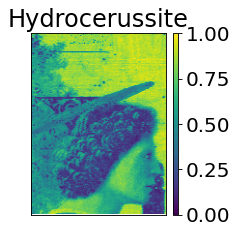

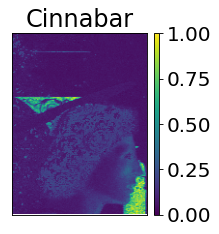

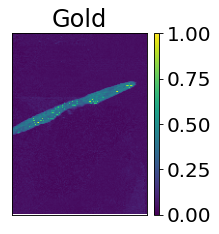

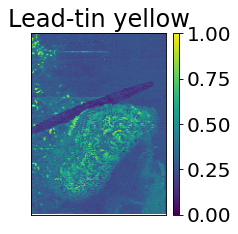

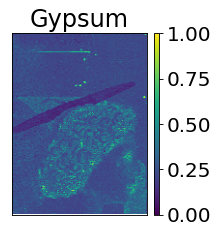

In [68]:
rcParams['font.size'] = 18

matrix_plot = criterion.copy()
matrix_plot /= matrix_plot.max(axis = 0, keepdims = True).max(axis = 1, keepdims = True)

for idx_phase, phase in enumerate(gm.phases):
    fig, ax  = subplots(figsize=(5,3))
    fig.set_dpi(80)
    title(phase.label)
    im = imshow(matrix_plot[..., idx_phase],
                vmin = 0, vmax = 1,
                origin = 'lower', cmap = 'viridis')
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])

    savefig(path_figures + 'primary - ' + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)
show()

### Save TIF files

In [69]:
matrix_components_tiff = criterion.copy()
for p in range(matrix_components_tiff.shape[2]):
    matrix_components_tiff[..., p] = matrix_components_tiff[..., p] / matrix_components_tiff[..., p].max()
matrix_components_tiff = flip((matrix_components_tiff * 65535).astype('uint16'), axis = [0])

for idx_phase,phase in enumerate(gm.phases):
    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + 'primary - ' + phase.label + '.tiff')
    img.save(path_figures + 'primary - ' + phase.label + '.png')

# Save .cif files

In [70]:
for phase in experimental_phases:
    filename = path_database_exp + phase.label + '.cif'
    print(filename)
    phase.save_cif(filename)

databaseEXP/MunchMuseum/M491/Hydrocerussite.cif
databaseEXP/MunchMuseum/M491/Cinnabar.cif
databaseEXP/MunchMuseum/M491/Gold.cif
databaseEXP/MunchMuseum/M491/Lead-tin yellow.cif
databaseEXP/MunchMuseum/M491/Gypsum.cif


# Explore one pixel with decomposition of experimental phases

In [73]:
x, y = 100, 150

cs = ChiSearch(experimental_phases, gm.get_pixel(x, y).spectrum, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)
cs.fit_cycle(steps = 8, chi = True)
#cs.search()

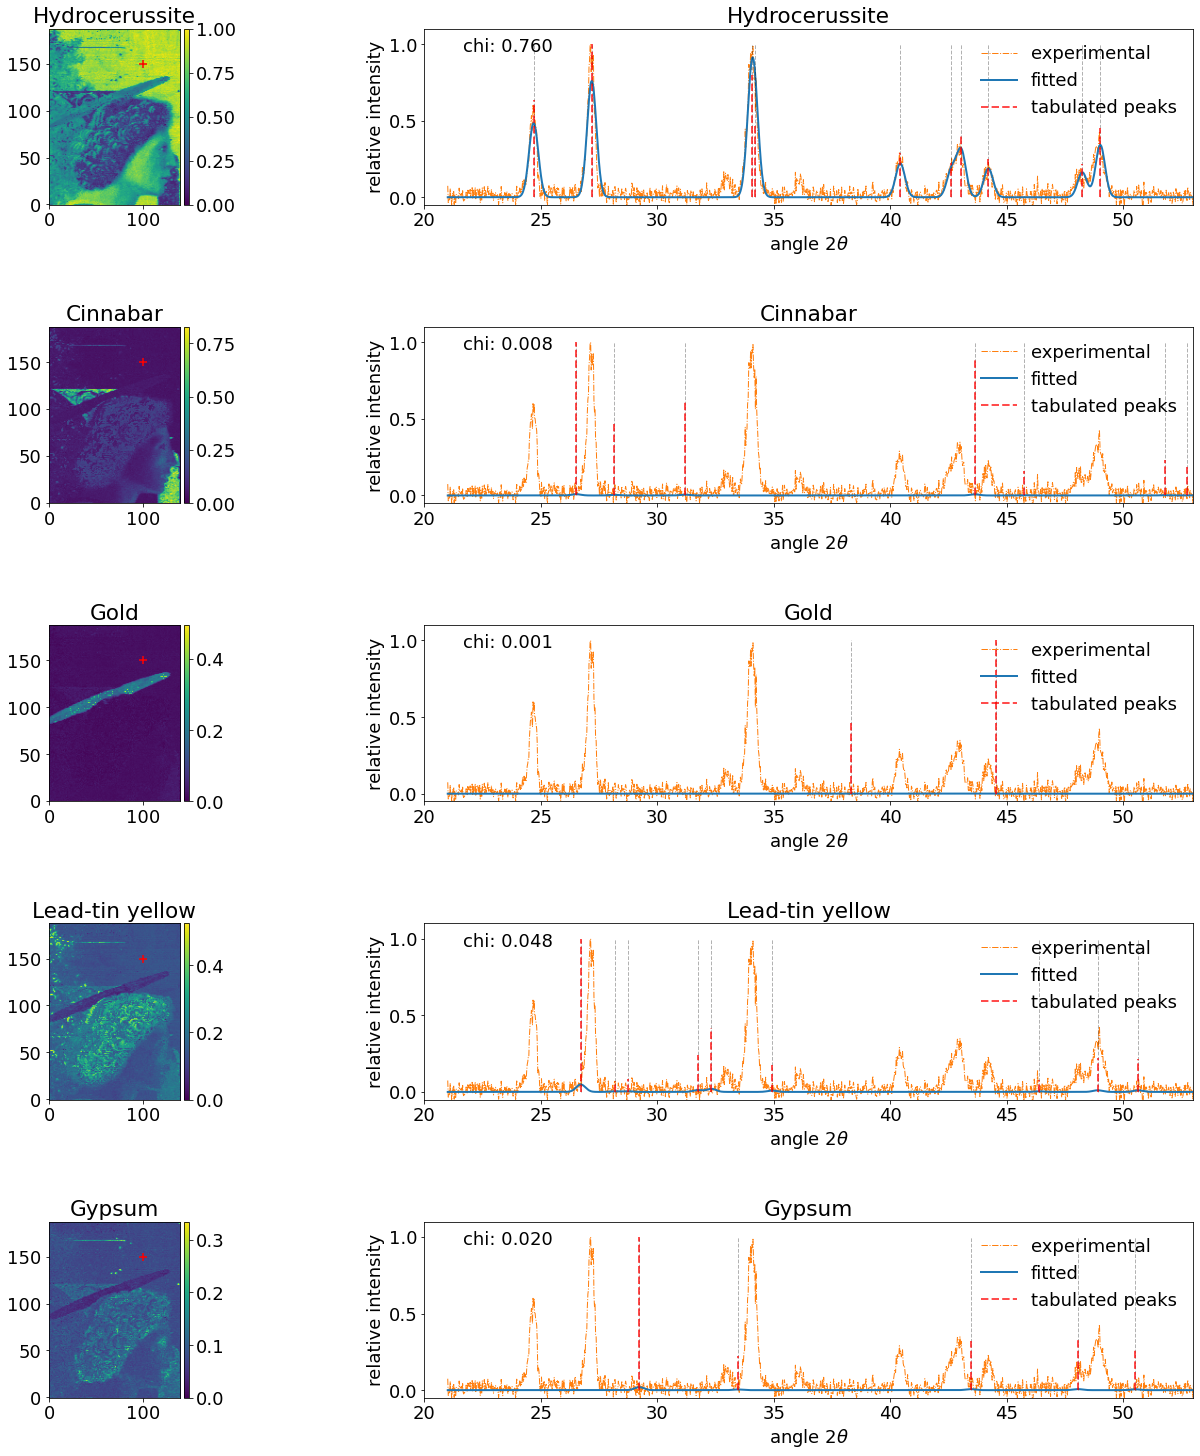

In [74]:
rcParams['font.size'] = 18
#matrix_plot = overlap_area.copy()
matrix_plot = criterion.copy()
matrix_plot /= matrix_plot.max()

fig, axs = subplots(len(cs), 2, figsize = (18, 4*len(cs)),
                   gridspec_kw = {'width_ratios': [1, 3]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, g in enumerate(cs):
    if (len(cs) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    sca(ax)
    im = imshow(matrix_plot[..., i], vmin = 0)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    scatter(x, y, s = 50, c = 'red', marker = '+')
    ax.set_title(g.label)

    if (len(cs) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    sca(ax)
    g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
    plot(cs[0].theta, cs.z_decomposed()[:, i], c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
    g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
    g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
    ax.annotate(f'chi: {cs.chi.squeeze()[i]:.3f}', xy = (0.05, 0.95),
        xycoords = 'axes fraction', horizontalalignment = 'left', verticalalignment = 'top')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1.1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(g.label)
    legend(frameon=False)

show()

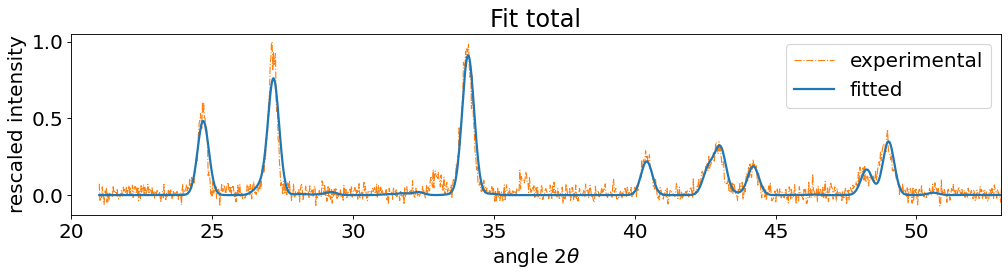

In [75]:
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 3))
sca(ax)
cs[0].plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
plot(cs[0].theta, cs.z(), c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
ax.set_xlim(min_theta, max_theta)
ax.legend(loc = 'upper right')
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('rescaled intensity')
ax.set_title('Fit total')
fig.set_dpi(80)
show()

# Fit errrors

Plotting the histograms and maps of the error for each phase. 

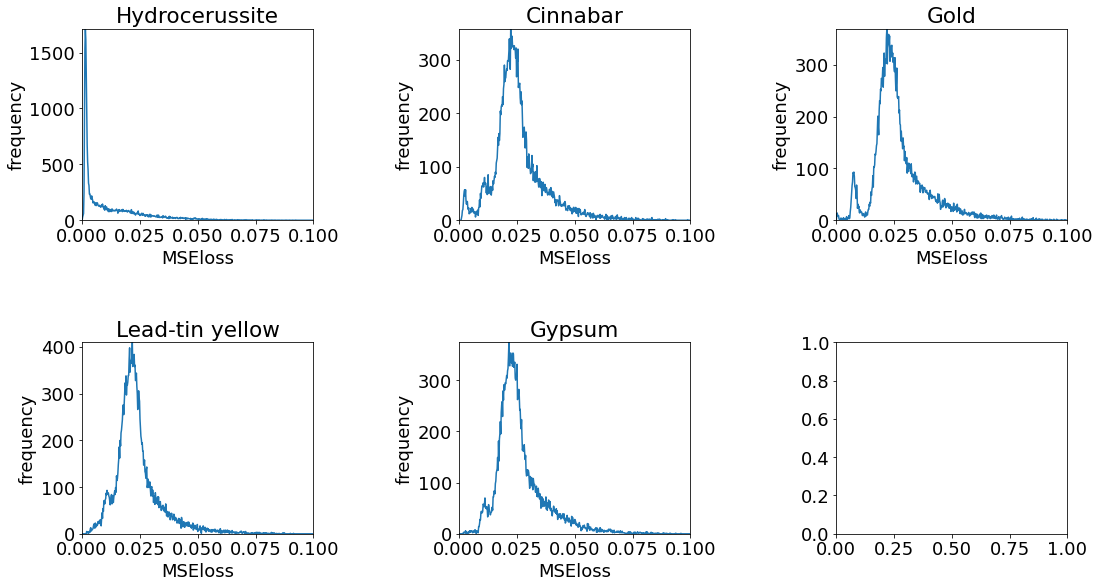

In [76]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (5 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 5, w_pad = 5)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[:, :, i], bins = 512,range = (0, 0.1))
    ax.plot(b[:-1], h)
    ax.set_xlim(0, b.max())
    ax.set_ylim(0, h.max())
    ax.set_xlabel('MSEloss')
    ax.set_ylabel('frequency')
    ax.set_title(phase.label)
show()

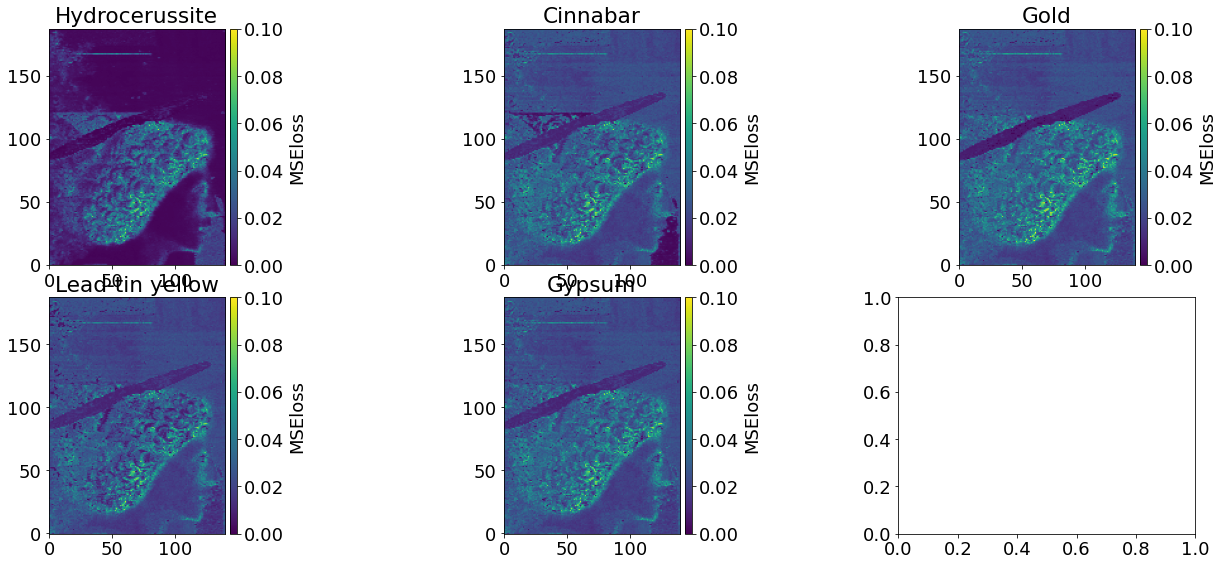

In [77]:
%matplotlib inline
n_of_columns = 3
rcParams['font.size'] = 18

n_of_pictures = len(gm.phases)
n_of_rows = n_of_pictures // n_of_columns
if (n_of_pictures % n_of_columns):
    n_of_rows += 1

fig, axs = subplots(n_of_rows, n_of_columns, figsize = (6 * n_of_columns, 4 * n_of_rows))
fig.tight_layout(h_pad = 0, w_pad = 6)
for i, phase in enumerate(gm.phases):
    i_row = i // n_of_columns
    i_column = i % n_of_columns
    if n_of_rows == 1:
        ax = axs[i_column]
    else:
        ax = axs[i_row, i_column]
    h, b = histogram(MSEloss[:, :, i], bins = 512,range = (0, 0.1))
    ax.set_title(phase.label)
    im = ax.imshow(MSEloss[:, :, i], vmin = 0, vmax = 0.1)
    cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
    cbar.set_label('MSEloss')
show()

# Search for secondary phases

#### Smooth data

In [78]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = data.generate_smooth(step, method)

Generating smooth data...
Removing background...
Done.
Done.


#### Check rescaling factor

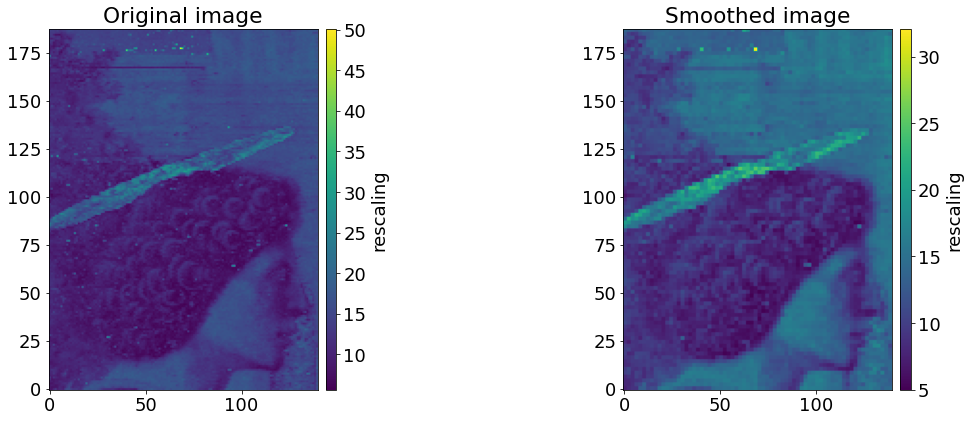

In [79]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 6))
fig.tight_layout(w_pad = 6)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze()**0.5)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Original image')

ax = axs[1]
im = ax.imshow(data_smooth.rescaling.squeeze()**0.5)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Smoothed image')

show()

#### Refit primary phases on smoothed data

In [80]:
%%time
gm1 = GammaMap().from_data(data_smooth, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm1 = gm1.search()

overlap_area_1 = gm1.overlap_area()

Using 8 CPUs
CPU times: user 31.9 s, sys: 3.64 s, total: 35.5 s
Wall time: 54.2 s


#### Fit secondary phases

In [81]:
%%time

phases_secondary = [hematite, bone_black, goethite]

gm2 = GammaMap_Secondary().from_data(gm1, data_smooth, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm2 = gm2.fit_cycle(steps = 6, gamma = True)

#overlap_area_compare_2 = gm2.overlap_area_compare()
overlap_area_compare_2 = gm2.overlap_area_difference()

Using 8 CPUs
CPU times: user 46.2 s, sys: 8.08 s, total: 54.3 s
Wall time: 1min


#### Quantify phase presence

In [82]:
correction = data_smooth.rescaling**0.5
#correction = data_smooth.signal_background_ratio

criterion_1 = overlap_area_1 * correction
criterion_2 = overlap_area_compare_2 * correction

# Plots

### Primary phases

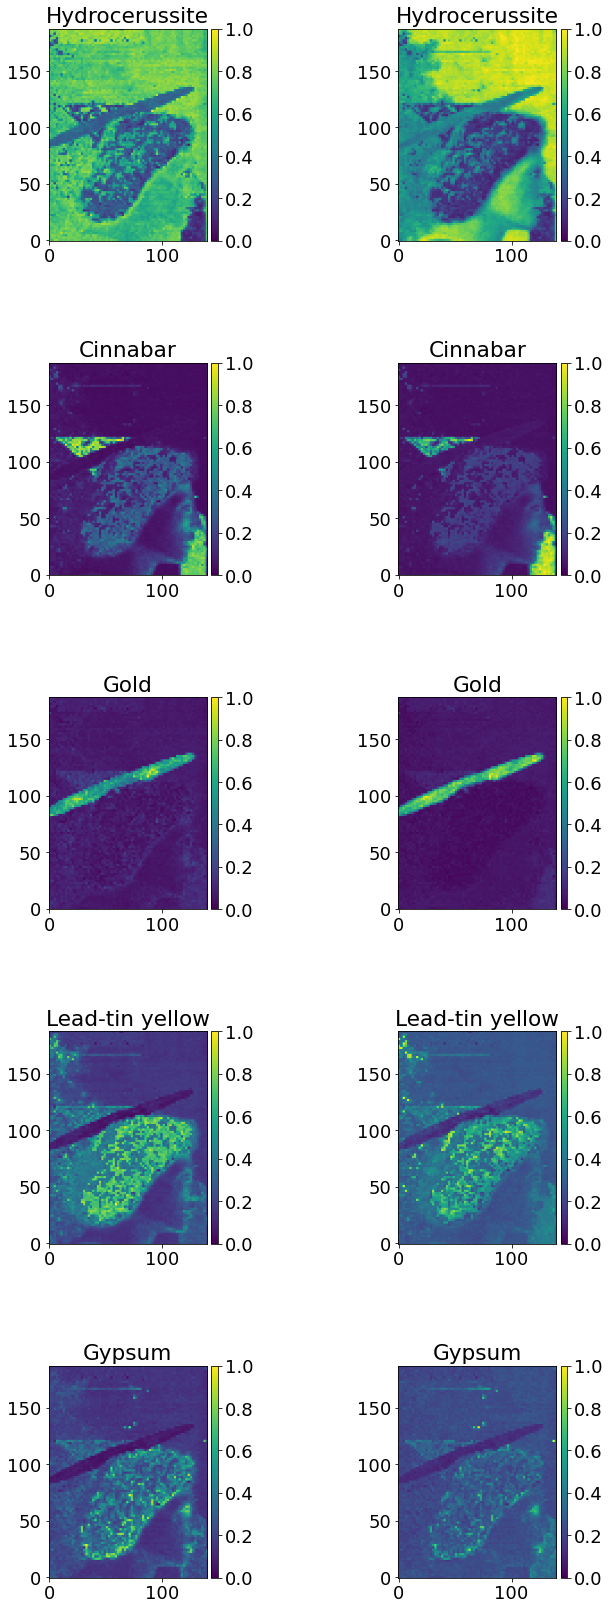

In [85]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm1.phases), 2, figsize = (9, 4.5 * len(gm1.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i, phase in enumerate(gm1.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area_1[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion_1[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

show()

### Secondary phases

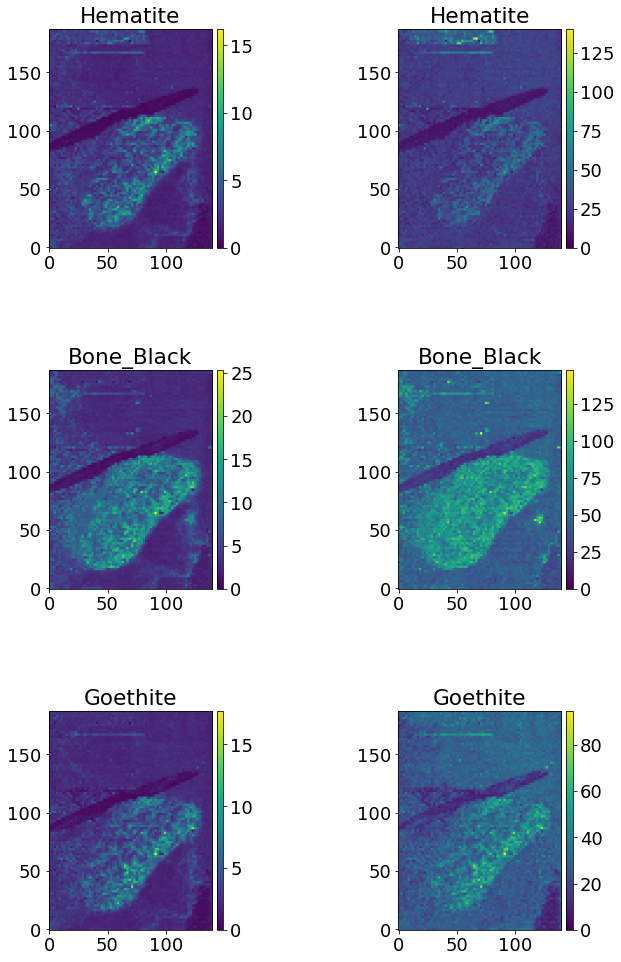

In [86]:
%matplotlib inline
rcParams['font.size'] = 18

fig, axs = subplots(len(gm2.phases), 2, figsize = (9, 4.5 * len(gm2.phases)))
fig.tight_layout(h_pad = 5, w_pad = 5)

for i, phase in enumerate(gm2.phases):
    ax = axs[i, 0]
    ax.set_title(phase.label)
    matrix_plot = overlap_area_compare_2[..., i].copy()
    #matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

    ax = axs[i, 1]
    ax.set_title(phase.label)
    matrix_plot = criterion_2[..., i].copy()
    #matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))

show()

### Save maps of secondary phases as PNG and TIF

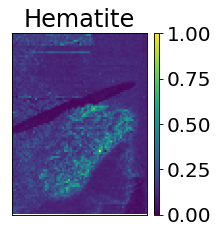

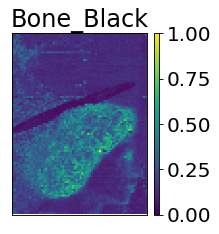

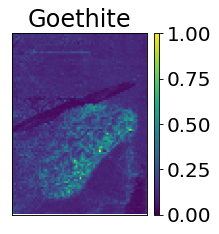

In [87]:
rcParams['font.size'] = 18

matrix_components_tiff = overlap_area_compare_2.copy()
matrix_components_tiff /= matrix_components_tiff.max(axis = 0, keepdims = True).max(axis = 1, keepdims = True)
matrix_components_tiff = flip((matrix_components_tiff * 65535).astype('uint16'), axis = [0])

for idx_phase, phase in enumerate(gm2.phases):
    fig, ax  = subplots(figsize=(5,3))
    fig.set_dpi(80)
    title(phase.label)
    matrix_plot = overlap_area_compare_2[..., idx_phase].copy()
    matrix_plot /= matrix_plot.max()
    im = imshow(matrix_plot, vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])

    savefig(path_figures + 'secondary - ' + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + 'secondary - ' + phase.label + '.tiff')
    img.save(path_figures + 'secondary - ' + phase.label + '.png')

show()

# Verify overlap of secondary phases in chosen pixel

Primary phases: 0.8297 of experimental area
Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases
Hematite:	0.0209
Bone_Black:	0.0343
Goethite:	0.0265


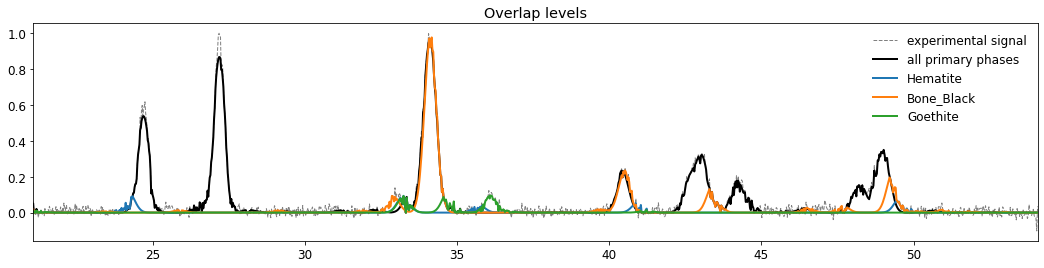

In [88]:
x, y = 100, 150
rcParams['font.size'] = 12

gs2 = gm2.get_pixel(x, y)

fig, ax = subplots(figsize = (18, 4))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
print(f'Primary phases: {gs2.gammasearch_1.overlap_total_ratio():.4f} of experimental area')
print('Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases')
for j in range(len(gs2)):
    ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)
    print(f'{gs2[j].label}:\t{gs2.overlap_area_compare()[j]:.4f}')

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap levels')
show()